In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma, 
               states, actions, next_states, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size,
                                         action_size=action_size, state_size=state_size)
    a_next_states_logits, aQlogits = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                         axis=1))
    eloss += -tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                   labels=next_states_labels), 
                                           axis=1))
    aloss2 = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                  labels=next_states_labels), 
                                          axis=1))
    #################################################### 
    eQlogits = tf.reshape(eQlogits, shape=[-1])
    aQlogits = tf.reshape(aQlogits, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQlogits,
                                                                    labels=rates))
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQlogits,
                                                                    labels=tf.zeros_like(rates))) # min prob
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQlogits,
                                                                     labels=tf.ones_like(rates))) # max prob
#     eloss += tf.reduce_mean(tf.square(aQlogits)) # min value
#     aloss2 += -tf.reduce_mean(tf.square(aQlogits)) # max value
    eloss += tf.reduce_mean(aQlogits) # min value
    aloss2 += -tf.reduce_mean(aQlogits) # max value
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _next_states_logits_, nextQlogits = Env(actions=next_actions_logits, states=next_states,
                                            hidden_size=hidden_size, action_size=action_size, 
                                            state_size=state_size, reuse=True)
    nextQlogits = tf.reshape(nextQlogits, shape=[-1]) * (1-dones)
    nextQlabels = tf.nn.sigmoid(nextQlogits)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQlogits,
                                                                    labels=nextQlabels)) 
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQlogits,
                                                                    labels=tf.zeros_like(rates))) # min prob
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQlogits,
                                                                     labels=tf.ones_like(rates))) # max prob
#     eloss += tf.reduce_mean(tf.square(nextQlogits)) # min value
#     aloss2 += -tf.reduce_mean(tf.square(nextQlogits)) # max value
    eloss += tf.reduce_mean(nextQlogits) # min value
    aloss2 += -tf.reduce_mean(nextQlogits) # max value
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, dones=self.dones, 
            rates=self.rates)
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
rate = -1
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset
        rate = -1 # reseta

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:0.6975 eloss:2.3170 aloss2:4.7045 exploreP:0.9984
Episode:1 meanR:18.5000 R:21.0000 rate:0.0420 aloss:0.6926 eloss:2.4072 aloss2:4.6072 exploreP:0.9963
Episode:2 meanR:23.0000 R:32.0000 rate:0.0640 aloss:0.6918 eloss:2.4200 aloss2:4.5925 exploreP:0.9932
Episode:3 meanR:20.0000 R:11.0000 rate:0.0220 aloss:0.6906 eloss:2.3755 aloss2:4.6271 exploreP:0.9921
Episode:4 meanR:18.4000 R:12.0000 rate:0.0240 aloss:0.6887 eloss:2.4487 aloss2:4.5547 exploreP:0.9909
Episode:5 meanR:17.8333 R:15.0000 rate:0.0300 aloss:0.6915 eloss:2.3728 aloss2:4.6331 exploreP:0.9895
Episode:6 meanR:17.8571 R:18.0000 rate:0.0360 aloss:0.6906 eloss:2.4205 aloss2:4.5658 exploreP:0.9877
Episode:7 meanR:18.5000 R:23.0000 rate:0.0460 aloss:0.6924 eloss:2.3628 aloss2:4.6461 exploreP:0.9855
Episode:8 meanR:17.5556 R:10.0000 rate:0.0200 aloss:0.6894 eloss:2.3845 aloss2:4.6121 exploreP:0.9845
Episode:9 meanR:18.1000 R:23.0000 rate:0.0460 aloss:0.6872 eloss:2.3286 aloss2:4.6

Episode:80 meanR:21.3086 R:14.0000 rate:0.0280 aloss:0.7044 eloss:-3.7142 aloss2:13.0023 exploreP:0.8431
Episode:81 meanR:21.2195 R:14.0000 rate:0.0280 aloss:0.6905 eloss:-4.0313 aloss2:13.7067 exploreP:0.8419
Episode:82 meanR:21.2530 R:24.0000 rate:0.0480 aloss:0.7037 eloss:-4.0683 aloss2:13.6862 exploreP:0.8399
Episode:83 meanR:21.1786 R:15.0000 rate:0.0300 aloss:0.7035 eloss:-4.0610 aloss2:13.6739 exploreP:0.8387
Episode:84 meanR:21.4471 R:44.0000 rate:0.0880 aloss:0.6927 eloss:-4.0852 aloss2:13.7426 exploreP:0.8350
Episode:85 meanR:21.3256 R:11.0000 rate:0.0220 aloss:0.6964 eloss:-4.6968 aloss2:15.0552 exploreP:0.8341
Episode:86 meanR:21.2989 R:19.0000 rate:0.0380 aloss:0.6912 eloss:-4.0589 aloss2:13.6132 exploreP:0.8325
Episode:87 meanR:21.2614 R:18.0000 rate:0.0360 aloss:0.6962 eloss:-4.6593 aloss2:14.8047 exploreP:0.8311
Episode:88 meanR:21.2247 R:18.0000 rate:0.0360 aloss:0.6942 eloss:-4.7494 aloss2:14.8711 exploreP:0.8296
Episode:89 meanR:21.5667 R:52.0000 rate:0.1040 aloss:0.

Episode:158 meanR:30.8200 R:18.0000 rate:0.0360 aloss:0.6797 eloss:-23.9421 aloss2:59.4314 exploreP:0.6491
Episode:159 meanR:30.8100 R:19.0000 rate:0.0380 aloss:0.6840 eloss:-24.7058 aloss2:61.1578 exploreP:0.6479
Episode:160 meanR:30.7000 R:18.0000 rate:0.0360 aloss:0.6786 eloss:-24.9712 aloss2:61.1593 exploreP:0.6468
Episode:161 meanR:30.9900 R:45.0000 rate:0.0900 aloss:0.6817 eloss:-24.8369 aloss2:60.9871 exploreP:0.6439
Episode:162 meanR:31.5400 R:70.0000 rate:0.1400 aloss:0.6809 eloss:-26.1948 aloss2:64.7450 exploreP:0.6395
Episode:163 meanR:31.5400 R:28.0000 rate:0.0560 aloss:0.6784 eloss:-26.3083 aloss2:65.1588 exploreP:0.6377
Episode:164 meanR:32.1000 R:74.0000 rate:0.1480 aloss:0.6808 eloss:-27.4569 aloss2:67.5073 exploreP:0.6331
Episode:165 meanR:32.7200 R:77.0000 rate:0.1540 aloss:0.6768 eloss:-28.3028 aloss2:69.5119 exploreP:0.6283
Episode:166 meanR:33.1600 R:57.0000 rate:0.1140 aloss:0.6786 eloss:-29.3550 aloss2:71.9724 exploreP:0.6248
Episode:167 meanR:33.4700 R:49.0000 r

Episode:234 meanR:137.5800 R:235.0000 rate:0.4700 aloss:0.6690 eloss:-651.0600 aloss2:1659.2809 exploreP:0.1915
Episode:235 meanR:139.8700 R:294.0000 rate:0.5880 aloss:0.6721 eloss:-677.9152 aloss2:1734.5699 exploreP:0.1863
Episode:236 meanR:144.5900 R:496.0000 rate:0.9920 aloss:0.6711 eloss:-737.3366 aloss2:1855.9552 exploreP:0.1777
Episode:237 meanR:146.7300 R:294.0000 rate:0.5880 aloss:0.6704 eloss:-775.1757 aloss2:1973.4080 exploreP:0.1729
Episode:238 meanR:148.7600 R:232.0000 rate:0.4640 aloss:0.6728 eloss:-819.6414 aloss2:2078.8140 exploreP:0.1691
Episode:239 meanR:150.3000 R:170.0000 rate:0.3400 aloss:0.6741 eloss:-820.4814 aloss2:2122.3286 exploreP:0.1664
Episode:240 meanR:153.4800 R:369.0000 rate:0.7380 aloss:0.6755 eloss:-873.9088 aloss2:2224.7065 exploreP:0.1608
Episode:241 meanR:155.3600 R:202.0000 rate:0.4040 aloss:0.6703 eloss:-905.5801 aloss2:2327.0093 exploreP:0.1578
Episode:242 meanR:156.8100 R:160.0000 rate:0.3200 aloss:0.6717 eloss:-929.8141 aloss2:2386.0403 exploreP

Episode:307 meanR:269.0200 R:384.0000 rate:0.7680 aloss:0.6702 eloss:-6166.5117 aloss2:17067.3008 exploreP:0.0354
Episode:308 meanR:269.1700 R:131.0000 rate:0.2620 aloss:0.6651 eloss:-6436.3350 aloss2:17352.7129 exploreP:0.0351
Episode:309 meanR:267.7600 R:76.0000 rate:0.1520 aloss:0.6627 eloss:-6387.0405 aloss2:17477.1113 exploreP:0.0349
Episode:310 meanR:267.3800 R:107.0000 rate:0.2140 aloss:0.6635 eloss:-6406.7739 aloss2:17619.1641 exploreP:0.0346
Episode:311 meanR:266.4100 R:89.0000 rate:0.1780 aloss:0.6699 eloss:-6518.3320 aloss2:17787.7891 exploreP:0.0344
Episode:312 meanR:262.6300 R:98.0000 rate:0.1960 aloss:0.6529 eloss:-6249.8857 aloss2:17966.6328 exploreP:0.0342
Episode:313 meanR:260.0000 R:142.0000 rate:0.2840 aloss:0.6590 eloss:-6606.9126 aloss2:18119.7227 exploreP:0.0338
Episode:314 meanR:256.6100 R:126.0000 rate:0.2520 aloss:0.6623 eloss:-6733.7153 aloss2:18467.5098 exploreP:0.0335
Episode:315 meanR:256.1700 R:258.0000 rate:0.5160 aloss:0.6613 eloss:-6548.5000 aloss2:1863

Episode:379 meanR:247.9600 R:359.0000 rate:0.7180 aloss:0.6488 eloss:-20315.6523 aloss2:63601.1797 exploreP:0.0141
Episode:380 meanR:250.5300 R:500.0000 rate:1.0000 aloss:0.6541 eloss:-21590.9844 aloss2:65435.0625 exploreP:0.0139
Episode:381 meanR:251.1100 R:258.0000 rate:0.5160 aloss:0.6559 eloss:-21455.5234 aloss2:66775.9688 exploreP:0.0138
Episode:382 meanR:246.8000 R:69.0000 rate:0.1380 aloss:0.6760 eloss:-22436.3281 aloss2:67369.9297 exploreP:0.0138
Episode:383 meanR:246.3500 R:84.0000 rate:0.1680 aloss:0.6621 eloss:-22594.2969 aloss2:67427.7188 exploreP:0.0137
Episode:384 meanR:243.3300 R:90.0000 rate:0.1800 aloss:0.6572 eloss:-23245.0762 aloss2:68542.3594 exploreP:0.0137
Episode:385 meanR:243.5200 R:85.0000 rate:0.1700 aloss:0.6441 eloss:-21205.8594 aloss2:68381.2656 exploreP:0.0137
Episode:386 meanR:245.0300 R:461.0000 rate:0.9220 aloss:0.6516 eloss:-22801.2148 aloss2:69559.7031 exploreP:0.0135
Episode:387 meanR:242.5700 R:157.0000 rate:0.3140 aloss:0.6534 eloss:-22748.1367 alo

Episode:451 meanR:226.0400 R:500.0000 rate:1.0000 aloss:0.6079 eloss:-46412.5195 aloss2:152658.9062 exploreP:0.0108
Episode:452 meanR:226.4000 R:196.0000 rate:0.3920 aloss:0.5949 eloss:-45867.8867 aloss2:155633.3906 exploreP:0.0108
Episode:453 meanR:230.4800 R:500.0000 rate:1.0000 aloss:0.6023 eloss:-46890.8984 aloss2:158215.5781 exploreP:0.0107
Episode:454 meanR:230.6900 R:124.0000 rate:0.2480 aloss:0.5878 eloss:-47434.5586 aloss2:161326.0312 exploreP:0.0107
Episode:455 meanR:229.2600 R:109.0000 rate:0.2180 aloss:0.6169 eloss:-51184.5898 aloss2:162514.4375 exploreP:0.0107
Episode:456 meanR:227.3200 R:100.0000 rate:0.2000 aloss:0.5994 eloss:-46576.2266 aloss2:161322.7344 exploreP:0.0107
Episode:457 meanR:223.5100 R:119.0000 rate:0.2380 aloss:0.6176 eloss:-49866.9102 aloss2:162862.9219 exploreP:0.0107
Episode:458 meanR:220.3200 R:111.0000 rate:0.2220 aloss:0.5889 eloss:-48601.0664 aloss2:163000.6250 exploreP:0.0107
Episode:459 meanR:222.6200 R:500.0000 rate:1.0000 aloss:0.5836 eloss:-48

Episode:522 meanR:315.7300 R:500.0000 rate:1.0000 aloss:0.4679 eloss:-109427.3125 aloss2:435122.7812 exploreP:0.0101
Episode:523 meanR:319.9700 R:500.0000 rate:1.0000 aloss:0.4592 eloss:-106385.0078 aloss2:437882.5938 exploreP:0.0101
Episode:524 meanR:324.4000 R:500.0000 rate:1.0000 aloss:0.4619 eloss:-109896.5703 aloss2:449637.0000 exploreP:0.0101
Episode:525 meanR:328.5400 R:500.0000 rate:1.0000 aloss:0.4359 eloss:-108873.2344 aloss2:456828.0312 exploreP:0.0101
Episode:526 meanR:331.5500 R:500.0000 rate:1.0000 aloss:0.4505 eloss:-112030.8047 aloss2:465630.6562 exploreP:0.0101
Episode:527 meanR:328.7100 R:216.0000 rate:0.4320 aloss:0.4490 eloss:-113959.6875 aloss2:470909.9375 exploreP:0.0101
Episode:528 meanR:328.7100 R:208.0000 rate:0.4160 aloss:0.4609 eloss:-114307.2969 aloss2:470899.6250 exploreP:0.0101
Episode:529 meanR:333.0200 R:500.0000 rate:1.0000 aloss:0.4479 eloss:-116951.6172 aloss2:482641.5938 exploreP:0.0100
Episode:530 meanR:336.8900 R:500.0000 rate:1.0000 aloss:0.4279 e

Episode:592 meanR:426.0000 R:500.0000 rate:1.0000 aloss:0.3362 eloss:-257232.4219 aloss2:1186124.5000 exploreP:0.0100
Episode:593 meanR:426.0000 R:500.0000 rate:1.0000 aloss:0.3438 eloss:-262851.7812 aloss2:1205038.6250 exploreP:0.0100
Episode:594 meanR:426.0000 R:500.0000 rate:1.0000 aloss:0.3259 eloss:-267129.2188 aloss2:1223337.5000 exploreP:0.0100
Episode:595 meanR:426.0000 R:500.0000 rate:1.0000 aloss:0.3298 eloss:-269820.0312 aloss2:1240441.5000 exploreP:0.0100
Episode:596 meanR:426.0000 R:500.0000 rate:1.0000 aloss:0.3299 eloss:-273220.1562 aloss2:1255958.0000 exploreP:0.0100
Episode:597 meanR:427.5100 R:500.0000 rate:1.0000 aloss:0.3252 eloss:-277938.5625 aloss2:1274586.7500 exploreP:0.0100
Episode:598 meanR:427.5100 R:500.0000 rate:1.0000 aloss:0.3179 eloss:-280585.2500 aloss2:1291905.2500 exploreP:0.0100
Episode:599 meanR:427.5100 R:500.0000 rate:1.0000 aloss:0.3174 eloss:-283860.3438 aloss2:1310208.1250 exploreP:0.0100
Episode:600 meanR:427.5100 R:500.0000 rate:1.0000 aloss:

Episode:662 meanR:485.5600 R:500.0000 rate:1.0000 aloss:0.2846 eloss:-623701.3750 aloss2:2907597.7500 exploreP:0.0100
Episode:663 meanR:485.5600 R:500.0000 rate:1.0000 aloss:0.2820 eloss:-631657.5000 aloss2:2943263.7500 exploreP:0.0100
Episode:664 meanR:488.1700 R:500.0000 rate:1.0000 aloss:0.2819 eloss:-638136.1875 aloss2:2976893.7500 exploreP:0.0100
Episode:665 meanR:488.1700 R:500.0000 rate:1.0000 aloss:0.2790 eloss:-649465.9375 aloss2:3014611.2500 exploreP:0.0100
Episode:666 meanR:491.2300 R:500.0000 rate:1.0000 aloss:0.2789 eloss:-655427.4375 aloss2:3050782.2500 exploreP:0.0100
Episode:667 meanR:491.2300 R:500.0000 rate:1.0000 aloss:0.2780 eloss:-662810.0625 aloss2:3083593.0000 exploreP:0.0100
Episode:668 meanR:491.2300 R:500.0000 rate:1.0000 aloss:0.2765 eloss:-669270.1250 aloss2:3119036.2500 exploreP:0.0100
Episode:669 meanR:491.2300 R:500.0000 rate:1.0000 aloss:0.2757 eloss:-677403.3750 aloss2:3155398.2500 exploreP:0.0100
Episode:670 meanR:491.2300 R:500.0000 rate:1.0000 aloss:

Episode:732 meanR:495.1700 R:500.0000 rate:1.0000 aloss:0.2197 eloss:-1299899.6250 aloss2:6060972.5000 exploreP:0.0100
Episode:733 meanR:495.1700 R:500.0000 rate:1.0000 aloss:0.2163 eloss:-1311759.8750 aloss2:6119783.0000 exploreP:0.0100
Episode:734 meanR:495.1700 R:500.0000 rate:1.0000 aloss:0.2150 eloss:-1325552.6250 aloss2:6176673.5000 exploreP:0.0100
Episode:735 meanR:495.1700 R:500.0000 rate:1.0000 aloss:0.2124 eloss:-1338160.5000 aloss2:6239593.5000 exploreP:0.0100
Episode:736 meanR:495.1700 R:500.0000 rate:1.0000 aloss:0.2146 eloss:-1350475.0000 aloss2:6297976.5000 exploreP:0.0100
Episode:737 meanR:495.1700 R:500.0000 rate:1.0000 aloss:0.2130 eloss:-1363749.3750 aloss2:6359908.5000 exploreP:0.0100
Episode:738 meanR:495.1700 R:500.0000 rate:1.0000 aloss:0.2137 eloss:-1377534.6250 aloss2:6420380.5000 exploreP:0.0100
Episode:739 meanR:495.1700 R:500.0000 rate:1.0000 aloss:0.2137 eloss:-1389797.1250 aloss2:6483692.0000 exploreP:0.0100
Episode:740 meanR:495.1700 R:500.0000 rate:1.000

Episode:801 meanR:446.9200 R:500.0000 rate:1.0000 aloss:0.1779 eloss:-2224914.5000 aloss2:10386579.0000 exploreP:0.0100
Episode:802 meanR:446.9200 R:500.0000 rate:1.0000 aloss:0.1747 eloss:-2245074.0000 aloss2:10481547.0000 exploreP:0.0100
Episode:803 meanR:446.9200 R:500.0000 rate:1.0000 aloss:0.1744 eloss:-2264213.7500 aloss2:10565294.0000 exploreP:0.0100
Episode:804 meanR:446.9200 R:500.0000 rate:1.0000 aloss:0.1718 eloss:-2281529.2500 aloss2:10645689.0000 exploreP:0.0100
Episode:805 meanR:446.9200 R:500.0000 rate:1.0000 aloss:0.1708 eloss:-2301452.7500 aloss2:10738672.0000 exploreP:0.0100
Episode:806 meanR:446.9200 R:500.0000 rate:1.0000 aloss:0.1727 eloss:-2321695.2500 aloss2:10829672.0000 exploreP:0.0100
Episode:807 meanR:446.9200 R:500.0000 rate:1.0000 aloss:0.1705 eloss:-2340510.5000 aloss2:10923634.0000 exploreP:0.0100
Episode:808 meanR:446.9200 R:500.0000 rate:1.0000 aloss:0.1711 eloss:-2360130.7500 aloss2:11016133.0000 exploreP:0.0100
Episode:809 meanR:446.9200 R:500.0000 ra

Episode:870 meanR:422.0600 R:500.0000 rate:1.0000 aloss:0.1506 eloss:-3523534.2500 aloss2:16453596.0000 exploreP:0.0100
Episode:871 meanR:422.0600 R:500.0000 rate:1.0000 aloss:0.1521 eloss:-3544069.7500 aloss2:16535583.0000 exploreP:0.0100
Episode:872 meanR:422.0600 R:500.0000 rate:1.0000 aloss:0.1526 eloss:-3574605.2500 aloss2:16696828.0000 exploreP:0.0100
Episode:873 meanR:422.0600 R:500.0000 rate:1.0000 aloss:0.1513 eloss:-3600455.0000 aloss2:16805756.0000 exploreP:0.0100
Episode:874 meanR:422.0800 R:19.0000 rate:0.0380 aloss:0.1485 eloss:-3616139.7500 aloss2:16875162.0000 exploreP:0.0100
Episode:875 meanR:426.9700 R:500.0000 rate:1.0000 aloss:0.1490 eloss:-3629630.5000 aloss2:16939906.0000 exploreP:0.0100
Episode:876 meanR:426.9700 R:500.0000 rate:1.0000 aloss:0.1513 eloss:-3659061.7500 aloss2:17096116.0000 exploreP:0.0100
Episode:877 meanR:425.1800 R:321.0000 rate:0.6420 aloss:0.1505 eloss:-3679772.0000 aloss2:17183670.0000 exploreP:0.0100
Episode:878 meanR:425.1800 R:500.0000 rat

Episode:939 meanR:353.4400 R:413.0000 rate:0.8260 aloss:0.1428 eloss:-4869063.5000 aloss2:22739976.0000 exploreP:0.0100
Episode:940 meanR:354.2300 R:90.0000 rate:0.1800 aloss:0.1473 eloss:-4895160.0000 aloss2:22878824.0000 exploreP:0.0100
Episode:941 meanR:354.2300 R:500.0000 rate:1.0000 aloss:0.1417 eloss:-4903466.5000 aloss2:22890928.0000 exploreP:0.0100
Episode:942 meanR:354.2300 R:500.0000 rate:1.0000 aloss:0.1409 eloss:-4941298.5000 aloss2:23064236.0000 exploreP:0.0100
Episode:943 meanR:349.5300 R:30.0000 rate:0.0600 aloss:0.1395 eloss:-4975659.0000 aloss2:23267242.0000 exploreP:0.0100
Episode:944 meanR:349.5300 R:500.0000 rate:1.0000 aloss:0.1440 eloss:-4975962.5000 aloss2:23235084.0000 exploreP:0.0100
Episode:945 meanR:349.5300 R:500.0000 rate:1.0000 aloss:0.1420 eloss:-5018817.5000 aloss2:23449164.0000 exploreP:0.0100
Episode:946 meanR:344.9500 R:42.0000 rate:0.0840 aloss:0.1471 eloss:-5022722.5000 aloss2:23432702.0000 exploreP:0.0100
Episode:947 meanR:340.1600 R:21.0000 rate:0

Episode:1008 meanR:343.1300 R:12.0000 rate:0.0240 aloss:0.1317 eloss:-6782329.5000 aloss2:31719518.0000 exploreP:0.0100
Episode:1009 meanR:348.0000 R:500.0000 rate:1.0000 aloss:0.1321 eloss:-6791275.5000 aloss2:31743500.0000 exploreP:0.0100
Episode:1010 meanR:352.6100 R:500.0000 rate:1.0000 aloss:0.1316 eloss:-6828713.0000 aloss2:31903566.0000 exploreP:0.0100
Episode:1011 meanR:352.6100 R:500.0000 rate:1.0000 aloss:0.1293 eloss:-6873676.5000 aloss2:32107172.0000 exploreP:0.0100
Episode:1012 meanR:347.8000 R:19.0000 rate:0.0380 aloss:0.1273 eloss:-6922257.5000 aloss2:32379136.0000 exploreP:0.0100
Episode:1013 meanR:347.8000 R:500.0000 rate:1.0000 aloss:0.1308 eloss:-6915624.5000 aloss2:32312750.0000 exploreP:0.0100
Episode:1014 meanR:352.5100 R:500.0000 rate:1.0000 aloss:0.1310 eloss:-6983271.0000 aloss2:32653390.0000 exploreP:0.0100
Episode:1015 meanR:355.8200 R:360.0000 rate:0.7200 aloss:0.1291 eloss:-7023994.5000 aloss2:32842792.0000 exploreP:0.0100
Episode:1016 meanR:355.8200 R:500.

Episode:1076 meanR:400.5100 R:500.0000 rate:1.0000 aloss:0.1313 eloss:-9598118.0000 aloss2:44888748.0000 exploreP:0.0100
Episode:1077 meanR:405.4000 R:500.0000 rate:1.0000 aloss:0.1257 eloss:-9667521.0000 aloss2:45216636.0000 exploreP:0.0100
Episode:1078 meanR:410.2800 R:500.0000 rate:1.0000 aloss:0.1322 eloss:-9718778.0000 aloss2:45463608.0000 exploreP:0.0100
Episode:1079 meanR:410.2800 R:500.0000 rate:1.0000 aloss:0.1241 eloss:-9777081.0000 aloss2:45725308.0000 exploreP:0.0100
Episode:1080 meanR:410.2800 R:500.0000 rate:1.0000 aloss:0.1247 eloss:-9819565.0000 aloss2:45915180.0000 exploreP:0.0100
Episode:1081 meanR:410.2800 R:500.0000 rate:1.0000 aloss:0.1277 eloss:-9878540.0000 aloss2:46195828.0000 exploreP:0.0100
Episode:1082 meanR:410.2800 R:500.0000 rate:1.0000 aloss:0.1225 eloss:-9965098.0000 aloss2:46618980.0000 exploreP:0.0100
Episode:1083 meanR:408.9400 R:366.0000 rate:0.7320 aloss:0.1264 eloss:-9996286.0000 aloss2:46766508.0000 exploreP:0.0100
Episode:1084 meanR:408.9400 R:50

Episode:1144 meanR:465.0500 R:500.0000 rate:1.0000 aloss:0.1120 eloss:-14085360.0000 aloss2:66003260.0000 exploreP:0.0100
Episode:1145 meanR:465.0500 R:500.0000 rate:1.0000 aloss:0.1087 eloss:-14135161.0000 aloss2:66200976.0000 exploreP:0.0100
Episode:1146 meanR:465.0500 R:500.0000 rate:1.0000 aloss:0.1146 eloss:-14300926.0000 aloss2:67089156.0000 exploreP:0.0100
Episode:1147 meanR:465.0500 R:500.0000 rate:1.0000 aloss:0.1085 eloss:-14371671.0000 aloss2:67387872.0000 exploreP:0.0100
Episode:1148 meanR:466.8600 R:500.0000 rate:1.0000 aloss:0.1083 eloss:-14431090.0000 aloss2:67653936.0000 exploreP:0.0100
Episode:1149 meanR:469.3200 R:500.0000 rate:1.0000 aloss:0.1106 eloss:-14441589.0000 aloss2:67655416.0000 exploreP:0.0100
Episode:1150 meanR:471.0500 R:500.0000 rate:1.0000 aloss:0.1132 eloss:-14546878.0000 aloss2:68161376.0000 exploreP:0.0100
Episode:1151 meanR:471.0500 R:500.0000 rate:1.0000 aloss:0.1122 eloss:-14649499.0000 aloss2:68676544.0000 exploreP:0.0100
Episode:1152 meanR:471.0

Episode:1212 meanR:488.2800 R:500.0000 rate:1.0000 aloss:0.1067 eloss:-20011988.0000 aloss2:93880616.0000 exploreP:0.0100
Episode:1213 meanR:488.2800 R:500.0000 rate:1.0000 aloss:0.1022 eloss:-20141928.0000 aloss2:94535976.0000 exploreP:0.0100
Episode:1214 meanR:488.2800 R:500.0000 rate:1.0000 aloss:0.1036 eloss:-20120794.0000 aloss2:94328520.0000 exploreP:0.0100
Episode:1215 meanR:488.2800 R:500.0000 rate:1.0000 aloss:0.1037 eloss:-20319228.0000 aloss2:95332632.0000 exploreP:0.0100
Episode:1216 meanR:490.1900 R:500.0000 rate:1.0000 aloss:0.1003 eloss:-20409966.0000 aloss2:95775520.0000 exploreP:0.0100
Episode:1217 meanR:490.1900 R:500.0000 rate:1.0000 aloss:0.1073 eloss:-20521322.0000 aloss2:96268200.0000 exploreP:0.0100
Episode:1218 meanR:490.1900 R:500.0000 rate:1.0000 aloss:0.1022 eloss:-20618622.0000 aloss2:96750832.0000 exploreP:0.0100
Episode:1219 meanR:491.6800 R:500.0000 rate:1.0000 aloss:0.1035 eloss:-20714346.0000 aloss2:97191952.0000 exploreP:0.0100
Episode:1220 meanR:491.6

Episode:1279 meanR:495.7900 R:500.0000 rate:1.0000 aloss:0.0989 eloss:-27639420.0000 aloss2:129757640.0000 exploreP:0.0100
Episode:1280 meanR:495.7900 R:500.0000 rate:1.0000 aloss:0.0964 eloss:-27740438.0000 aloss2:130239368.0000 exploreP:0.0100
Episode:1281 meanR:495.7900 R:500.0000 rate:1.0000 aloss:0.1000 eloss:-27801412.0000 aloss2:130452592.0000 exploreP:0.0100
Episode:1282 meanR:494.5800 R:379.0000 rate:0.7580 aloss:0.0974 eloss:-27927760.0000 aloss2:131056072.0000 exploreP:0.0100
Episode:1283 meanR:494.5800 R:500.0000 rate:1.0000 aloss:0.0971 eloss:-27966556.0000 aloss2:131216560.0000 exploreP:0.0100
Episode:1284 meanR:496.7800 R:500.0000 rate:1.0000 aloss:0.0975 eloss:-28058586.0000 aloss2:131602232.0000 exploreP:0.0100
Episode:1285 meanR:496.7800 R:500.0000 rate:1.0000 aloss:0.0979 eloss:-28250966.0000 aloss2:132548688.0000 exploreP:0.0100
Episode:1286 meanR:496.7800 R:500.0000 rate:1.0000 aloss:0.0963 eloss:-28406518.0000 aloss2:133311840.0000 exploreP:0.0100
Episode:1287 mea

Episode:1346 meanR:496.6900 R:500.0000 rate:1.0000 aloss:0.1023 eloss:-37366332.0000 aloss2:175598304.0000 exploreP:0.0100
Episode:1347 meanR:496.6900 R:500.0000 rate:1.0000 aloss:0.0992 eloss:-37422316.0000 aloss2:175799792.0000 exploreP:0.0100
Episode:1348 meanR:496.6900 R:500.0000 rate:1.0000 aloss:0.1033 eloss:-37681776.0000 aloss2:177060624.0000 exploreP:0.0100
Episode:1349 meanR:496.6900 R:500.0000 rate:1.0000 aloss:0.1050 eloss:-37704992.0000 aloss2:177083472.0000 exploreP:0.0100
Episode:1350 meanR:496.6900 R:500.0000 rate:1.0000 aloss:0.0976 eloss:-37891208.0000 aloss2:177996304.0000 exploreP:0.0100
Episode:1351 meanR:496.6900 R:500.0000 rate:1.0000 aloss:0.1047 eloss:-38350700.0000 aloss2:180305760.0000 exploreP:0.0100
Episode:1352 meanR:496.6900 R:500.0000 rate:1.0000 aloss:0.1030 eloss:-38454648.0000 aloss2:180758048.0000 exploreP:0.0100
Episode:1353 meanR:496.6900 R:500.0000 rate:1.0000 aloss:0.1028 eloss:-38564688.0000 aloss2:181273728.0000 exploreP:0.0100
Episode:1354 mea

Episode:1413 meanR:497.0700 R:500.0000 rate:1.0000 aloss:0.1108 eloss:-49719844.0000 aloss2:233854032.0000 exploreP:0.0100
Episode:1414 meanR:495.4800 R:341.0000 rate:0.6820 aloss:0.1159 eloss:-49813948.0000 aloss2:234240480.0000 exploreP:0.0100
Episode:1415 meanR:495.4800 R:500.0000 rate:1.0000 aloss:0.1104 eloss:-49954052.0000 aloss2:234930144.0000 exploreP:0.0100
Episode:1416 meanR:495.4800 R:500.0000 rate:1.0000 aloss:0.1127 eloss:-50238736.0000 aloss2:236282464.0000 exploreP:0.0100
Episode:1417 meanR:495.4800 R:500.0000 rate:1.0000 aloss:0.1144 eloss:-50532304.0000 aloss2:237702288.0000 exploreP:0.0100
Episode:1418 meanR:495.4800 R:500.0000 rate:1.0000 aloss:0.1131 eloss:-50852832.0000 aloss2:239305456.0000 exploreP:0.0100
Episode:1419 meanR:495.4800 R:500.0000 rate:1.0000 aloss:0.1121 eloss:-50875240.0000 aloss2:239281440.0000 exploreP:0.0100
Episode:1420 meanR:495.4800 R:500.0000 rate:1.0000 aloss:0.1151 eloss:-50852984.0000 aloss2:239078112.0000 exploreP:0.0100
Episode:1421 mea

Episode:1480 meanR:460.4500 R:500.0000 rate:1.0000 aloss:0.1522 eloss:-62740348.0000 aloss2:295190976.0000 exploreP:0.0100
Episode:1481 meanR:460.4500 R:500.0000 rate:1.0000 aloss:0.1541 eloss:-62714424.0000 aloss2:294948096.0000 exploreP:0.0100
Episode:1482 meanR:460.4500 R:500.0000 rate:1.0000 aloss:0.1741 eloss:-63005548.0000 aloss2:296353888.0000 exploreP:0.0100
Episode:1483 meanR:455.5600 R:11.0000 rate:0.0220 aloss:0.1798 eloss:-64852900.0000 aloss2:305836672.0000 exploreP:0.0100
Episode:1484 meanR:450.6700 R:11.0000 rate:0.0220 aloss:0.1569 eloss:-64723864.0000 aloss2:305134912.0000 exploreP:0.0100
Episode:1485 meanR:445.7900 R:12.0000 rate:0.0240 aloss:0.1392 eloss:-62538656.0000 aloss2:293846048.0000 exploreP:0.0100
Episode:1486 meanR:445.7900 R:500.0000 rate:1.0000 aloss:0.1505 eloss:-62953956.0000 aloss2:295942080.0000 exploreP:0.0100
Episode:1487 meanR:445.7900 R:500.0000 rate:1.0000 aloss:0.1572 eloss:-63431860.0000 aloss2:298307104.0000 exploreP:0.0100
Episode:1488 meanR:

Episode:1547 meanR:406.5700 R:500.0000 rate:1.0000 aloss:0.3446 eloss:-74197872.0000 aloss2:348266720.0000 exploreP:0.0100
Episode:1548 meanR:411.2700 R:500.0000 rate:1.0000 aloss:0.4495 eloss:-75206936.0000 aloss2:353330144.0000 exploreP:0.0100
Episode:1549 meanR:411.2700 R:500.0000 rate:1.0000 aloss:0.3370 eloss:-74831152.0000 aloss2:351341248.0000 exploreP:0.0100
Episode:1550 meanR:411.2700 R:500.0000 rate:1.0000 aloss:0.3763 eloss:-74932512.0000 aloss2:351706496.0000 exploreP:0.0100
Episode:1551 meanR:411.2700 R:500.0000 rate:1.0000 aloss:0.3159 eloss:-75378392.0000 aloss2:353848320.0000 exploreP:0.0100
Episode:1552 meanR:411.2700 R:500.0000 rate:1.0000 aloss:0.3192 eloss:-76038960.0000 aloss2:357230656.0000 exploreP:0.0100
Episode:1553 meanR:411.2700 R:500.0000 rate:1.0000 aloss:0.2891 eloss:-75795952.0000 aloss2:355797760.0000 exploreP:0.0100
Episode:1554 meanR:411.2700 R:500.0000 rate:1.0000 aloss:0.2996 eloss:-75724032.0000 aloss2:355396192.0000 exploreP:0.0100
Episode:1555 mea

Episode:1614 meanR:466.5600 R:500.0000 rate:1.0000 aloss:0.2880 eloss:-88449800.0000 aloss2:413785056.0000 exploreP:0.0100
Episode:1615 meanR:465.4700 R:391.0000 rate:0.7820 aloss:0.2912 eloss:-89052040.0000 aloss2:416824128.0000 exploreP:0.0100
Episode:1616 meanR:462.2600 R:179.0000 rate:0.3580 aloss:0.3630 eloss:-88227912.0000 aloss2:412482976.0000 exploreP:0.0100
Episode:1617 meanR:462.2600 R:500.0000 rate:1.0000 aloss:0.3263 eloss:-88962960.0000 aloss2:416239136.0000 exploreP:0.0100
Episode:1618 meanR:462.2600 R:500.0000 rate:1.0000 aloss:0.2878 eloss:-88855992.0000 aloss2:415659904.0000 exploreP:0.0100
Episode:1619 meanR:462.2600 R:500.0000 rate:1.0000 aloss:0.3650 eloss:-89020448.0000 aloss2:416285856.0000 exploreP:0.0100
Episode:1620 meanR:462.2600 R:500.0000 rate:1.0000 aloss:0.2735 eloss:-89691224.0000 aloss2:419475424.0000 exploreP:0.0100
Episode:1621 meanR:462.2600 R:500.0000 rate:1.0000 aloss:0.2872 eloss:-89362696.0000 aloss2:417846272.0000 exploreP:0.0100
Episode:1622 mea

Episode:1681 meanR:425.2100 R:466.0000 rate:0.9320 aloss:0.1818 eloss:-99363656.0000 aloss2:462559424.0000 exploreP:0.0100
Episode:1682 meanR:420.5500 R:34.0000 rate:0.0680 aloss:0.1674 eloss:-101363280.0000 aloss2:472226400.0000 exploreP:0.0100
Episode:1683 meanR:420.5500 R:500.0000 rate:1.0000 aloss:0.1777 eloss:-100369672.0000 aloss2:467595520.0000 exploreP:0.0100
Episode:1684 meanR:420.5500 R:500.0000 rate:1.0000 aloss:0.1773 eloss:-100411984.0000 aloss2:467530240.0000 exploreP:0.0100
Episode:1685 meanR:423.0500 R:317.0000 rate:0.6340 aloss:0.1828 eloss:-100376064.0000 aloss2:467303008.0000 exploreP:0.0100
Episode:1686 meanR:423.0500 R:500.0000 rate:1.0000 aloss:0.1756 eloss:-101235936.0000 aloss2:471548896.0000 exploreP:0.0100
Episode:1687 meanR:423.0500 R:500.0000 rate:1.0000 aloss:0.1697 eloss:-100759064.0000 aloss2:469159232.0000 exploreP:0.0100
Episode:1688 meanR:423.0500 R:500.0000 rate:1.0000 aloss:0.1748 eloss:-102503072.0000 aloss2:477681696.0000 exploreP:0.0100
Episode:16

Episode:1748 meanR:370.1200 R:37.0000 rate:0.0740 aloss:0.1294 eloss:-114215040.0000 aloss2:530930592.0000 exploreP:0.0100
Episode:1749 meanR:370.1200 R:500.0000 rate:1.0000 aloss:0.1268 eloss:-114895048.0000 aloss2:533716800.0000 exploreP:0.0100
Episode:1750 meanR:370.1200 R:500.0000 rate:1.0000 aloss:0.1394 eloss:-114956728.0000 aloss2:533857344.0000 exploreP:0.0100
Episode:1751 meanR:370.9500 R:500.0000 rate:1.0000 aloss:0.1210 eloss:-115754808.0000 aloss2:537739712.0000 exploreP:0.0100
Episode:1752 meanR:370.9500 R:500.0000 rate:1.0000 aloss:0.1370 eloss:-115605512.0000 aloss2:536884544.0000 exploreP:0.0100
Episode:1753 meanR:370.9500 R:500.0000 rate:1.0000 aloss:0.1238 eloss:-116297856.0000 aloss2:540278080.0000 exploreP:0.0100
Episode:1754 meanR:371.7800 R:500.0000 rate:1.0000 aloss:0.1312 eloss:-115902600.0000 aloss2:538150912.0000 exploreP:0.0100
Episode:1755 meanR:370.5500 R:377.0000 rate:0.7540 aloss:0.1307 eloss:-116200360.0000 aloss2:539419776.0000 exploreP:0.0100
Episode:1

Episode:1815 meanR:419.0600 R:500.0000 rate:1.0000 aloss:0.1109 eloss:-137145152.0000 aloss2:636740288.0000 exploreP:0.0100
Episode:1816 meanR:414.7300 R:67.0000 rate:0.1340 aloss:0.1125 eloss:-138395856.0000 aloss2:643465920.0000 exploreP:0.0100
Episode:1817 meanR:411.0800 R:96.0000 rate:0.1920 aloss:0.1040 eloss:-138618240.0000 aloss2:644071488.0000 exploreP:0.0100
Episode:1818 meanR:415.4600 R:500.0000 rate:1.0000 aloss:0.1205 eloss:-137573632.0000 aloss2:638688064.0000 exploreP:0.0100
Episode:1819 meanR:414.4200 R:396.0000 rate:0.7920 aloss:0.1047 eloss:-137364112.0000 aloss2:637575808.0000 exploreP:0.0100
Episode:1820 meanR:414.4200 R:500.0000 rate:1.0000 aloss:0.1158 eloss:-137510800.0000 aloss2:638008832.0000 exploreP:0.0100
Episode:1821 meanR:413.8900 R:447.0000 rate:0.8940 aloss:0.1109 eloss:-137330224.0000 aloss2:636924672.0000 exploreP:0.0100
Episode:1822 meanR:413.8900 R:500.0000 rate:1.0000 aloss:0.1108 eloss:-138532384.0000 aloss2:642871744.0000 exploreP:0.0100
Episode:18

Episode:1882 meanR:422.4800 R:13.0000 rate:0.0260 aloss:0.0896 eloss:-162956288.0000 aloss2:756834944.0000 exploreP:0.0100
Episode:1883 meanR:422.4800 R:500.0000 rate:1.0000 aloss:0.0994 eloss:-163812608.0000 aloss2:760900352.0000 exploreP:0.0100
Episode:1884 meanR:422.4800 R:500.0000 rate:1.0000 aloss:0.1005 eloss:-163173168.0000 aloss2:757214720.0000 exploreP:0.0100
Episode:1885 meanR:422.4800 R:500.0000 rate:1.0000 aloss:0.1000 eloss:-164132048.0000 aloss2:762031488.0000 exploreP:0.0100
Episode:1886 meanR:422.4800 R:500.0000 rate:1.0000 aloss:0.1022 eloss:-164349216.0000 aloss2:762747712.0000 exploreP:0.0100
Episode:1887 meanR:418.9300 R:145.0000 rate:0.2900 aloss:0.0959 eloss:-164417840.0000 aloss2:762890880.0000 exploreP:0.0100
Episode:1888 meanR:418.9300 R:500.0000 rate:1.0000 aloss:0.1024 eloss:-164724528.0000 aloss2:764526208.0000 exploreP:0.0100
Episode:1889 meanR:418.8200 R:489.0000 rate:0.9780 aloss:0.0985 eloss:-165211616.0000 aloss2:766620736.0000 exploreP:0.0100
Episode:1

Episode:1949 meanR:451.5200 R:500.0000 rate:1.0000 aloss:0.0896 eloss:-195062208.0000 aloss2:905904832.0000 exploreP:0.0100
Episode:1950 meanR:451.5200 R:500.0000 rate:1.0000 aloss:0.0972 eloss:-196315760.0000 aloss2:912057856.0000 exploreP:0.0100
Episode:1951 meanR:452.6100 R:500.0000 rate:1.0000 aloss:0.0879 eloss:-196497376.0000 aloss2:912756864.0000 exploreP:0.0100
Episode:1952 meanR:452.6100 R:500.0000 rate:1.0000 aloss:0.0940 eloss:-197200736.0000 aloss2:915953728.0000 exploreP:0.0100
Episode:1953 meanR:452.6100 R:500.0000 rate:1.0000 aloss:0.0924 eloss:-197866512.0000 aloss2:919285376.0000 exploreP:0.0100
Episode:1954 meanR:457.0800 R:500.0000 rate:1.0000 aloss:0.0922 eloss:-198331920.0000 aloss2:921255616.0000 exploreP:0.0100
Episode:1955 meanR:457.0800 R:500.0000 rate:1.0000 aloss:0.0946 eloss:-199002496.0000 aloss2:924506496.0000 exploreP:0.0100
Episode:1956 meanR:457.0800 R:500.0000 rate:1.0000 aloss:0.0888 eloss:-199011104.0000 aloss2:924195328.0000 exploreP:0.0100
Episode:

Episode:2015 meanR:455.8900 R:500.0000 rate:1.0000 aloss:0.0854 eloss:-228626624.0000 aloss2:1061295616.0000 exploreP:0.0100
Episode:2016 meanR:455.8900 R:500.0000 rate:1.0000 aloss:0.0932 eloss:-229101104.0000 aloss2:1063270464.0000 exploreP:0.0100
Episode:2017 meanR:453.0600 R:217.0000 rate:0.4340 aloss:0.0859 eloss:-230368368.0000 aloss2:1069794880.0000 exploreP:0.0100
Episode:2018 meanR:448.6000 R:54.0000 rate:0.1080 aloss:0.0901 eloss:-232190768.0000 aloss2:1079429760.0000 exploreP:0.0100
Episode:2019 meanR:448.6000 R:500.0000 rate:1.0000 aloss:0.0893 eloss:-231032320.0000 aloss2:1072945408.0000 exploreP:0.0100
Episode:2020 meanR:448.6000 R:500.0000 rate:1.0000 aloss:0.0851 eloss:-231852688.0000 aloss2:1076949376.0000 exploreP:0.0100
Episode:2021 meanR:448.6000 R:500.0000 rate:1.0000 aloss:0.0923 eloss:-231702736.0000 aloss2:1075713792.0000 exploreP:0.0100
Episode:2022 meanR:448.6000 R:500.0000 rate:1.0000 aloss:0.0850 eloss:-232228736.0000 aloss2:1078086528.0000 exploreP:0.0100
E

Episode:2081 meanR:443.0300 R:500.0000 rate:1.0000 aloss:0.0932 eloss:-269606848.0000 aloss2:1252425088.0000 exploreP:0.0100
Episode:2082 meanR:443.0300 R:500.0000 rate:1.0000 aloss:0.1000 eloss:-268912608.0000 aloss2:1248094592.0000 exploreP:0.0100
Episode:2083 meanR:445.4900 R:500.0000 rate:1.0000 aloss:0.0981 eloss:-270760640.0000 aloss2:1257778432.0000 exploreP:0.0100
Episode:2084 meanR:445.4900 R:500.0000 rate:1.0000 aloss:0.1096 eloss:-271406432.0000 aloss2:1260736512.0000 exploreP:0.0100
Episode:2085 meanR:450.3400 R:500.0000 rate:1.0000 aloss:0.0949 eloss:-271526496.0000 aloss2:1260781568.0000 exploreP:0.0100
Episode:2086 meanR:452.4000 R:384.0000 rate:0.7680 aloss:0.1166 eloss:-272616448.0000 aloss2:1266022272.0000 exploreP:0.0100
Episode:2087 meanR:451.6400 R:10.0000 rate:0.0200 aloss:0.1145 eloss:-271437824.0000 aloss2:1258494592.0000 exploreP:0.0100
Episode:2088 meanR:451.6400 R:500.0000 rate:1.0000 aloss:0.0959 eloss:-273825440.0000 aloss2:1272447872.0000 exploreP:0.0100
E

Episode:2147 meanR:471.8300 R:500.0000 rate:1.0000 aloss:0.1125 eloss:-316331104.0000 aloss2:1470653824.0000 exploreP:0.0100
Episode:2148 meanR:471.8300 R:500.0000 rate:1.0000 aloss:0.1160 eloss:-315271232.0000 aloss2:1463583488.0000 exploreP:0.0100
Episode:2149 meanR:471.7300 R:490.0000 rate:0.9800 aloss:0.1109 eloss:-317750144.0000 aloss2:1477054080.0000 exploreP:0.0100
Episode:2150 meanR:471.7300 R:500.0000 rate:1.0000 aloss:0.1064 eloss:-318266528.0000 aloss2:1479347072.0000 exploreP:0.0100
Episode:2151 meanR:471.7300 R:500.0000 rate:1.0000 aloss:0.1126 eloss:-318478880.0000 aloss2:1479525760.0000 exploreP:0.0100
Episode:2152 meanR:471.7300 R:500.0000 rate:1.0000 aloss:0.1092 eloss:-320380896.0000 aloss2:1489630208.0000 exploreP:0.0100
Episode:2153 meanR:471.7300 R:500.0000 rate:1.0000 aloss:0.1238 eloss:-321125024.0000 aloss2:1492951936.0000 exploreP:0.0100
Episode:2154 meanR:471.7300 R:500.0000 rate:1.0000 aloss:0.1149 eloss:-322214368.0000 aloss2:1498494848.0000 exploreP:0.0100


Episode:2213 meanR:459.6000 R:500.0000 rate:1.0000 aloss:0.1522 eloss:-365077408.0000 aloss2:1697254144.0000 exploreP:0.0100
Episode:2214 meanR:459.6000 R:500.0000 rate:1.0000 aloss:0.1275 eloss:-366002112.0000 aloss2:1701648640.0000 exploreP:0.0100
Episode:2215 meanR:459.6000 R:500.0000 rate:1.0000 aloss:0.1232 eloss:-366843360.0000 aloss2:1705528064.0000 exploreP:0.0100
Episode:2216 meanR:458.7700 R:417.0000 rate:0.8340 aloss:0.1622 eloss:-367648544.0000 aloss2:1709341056.0000 exploreP:0.0100
Episode:2217 meanR:458.7700 R:500.0000 rate:1.0000 aloss:0.1282 eloss:-368983072.0000 aloss2:1716429056.0000 exploreP:0.0100
Episode:2218 meanR:453.8800 R:11.0000 rate:0.0220 aloss:0.1007 eloss:-374190592.0000 aloss2:1747094272.0000 exploreP:0.0100
Episode:2219 meanR:453.8800 R:500.0000 rate:1.0000 aloss:0.1312 eloss:-369956032.0000 aloss2:1720986368.0000 exploreP:0.0100
Episode:2220 meanR:453.8800 R:500.0000 rate:1.0000 aloss:0.1384 eloss:-370604960.0000 aloss2:1723563136.0000 exploreP:0.0100
E

Episode:2279 meanR:466.3900 R:500.0000 rate:1.0000 aloss:0.1208 eloss:-420796704.0000 aloss2:1958336768.0000 exploreP:0.0100
Episode:2280 meanR:466.3900 R:500.0000 rate:1.0000 aloss:0.1003 eloss:-422690080.0000 aloss2:1968635776.0000 exploreP:0.0100
Episode:2281 meanR:465.3200 R:393.0000 rate:0.7860 aloss:0.1140 eloss:-423260000.0000 aloss2:1970758528.0000 exploreP:0.0100
Episode:2282 meanR:462.5300 R:221.0000 rate:0.4420 aloss:0.1196 eloss:-424487424.0000 aloss2:1977689344.0000 exploreP:0.0100
Episode:2283 meanR:462.5300 R:500.0000 rate:1.0000 aloss:0.0987 eloss:-424486240.0000 aloss2:1974385024.0000 exploreP:0.0100
Episode:2284 meanR:462.5300 R:500.0000 rate:1.0000 aloss:0.1208 eloss:-425431520.0000 aloss2:1980818304.0000 exploreP:0.0100
Episode:2285 meanR:462.5300 R:500.0000 rate:1.0000 aloss:0.1084 eloss:-426554496.0000 aloss2:1986380032.0000 exploreP:0.0100
Episode:2286 meanR:462.5300 R:500.0000 rate:1.0000 aloss:0.1087 eloss:-426677440.0000 aloss2:1985519488.0000 exploreP:0.0100


Episode:2345 meanR:429.8100 R:500.0000 rate:1.0000 aloss:0.1006 eloss:-476910656.0000 aloss2:2222831104.0000 exploreP:0.0100
Episode:2346 meanR:429.8100 R:500.0000 rate:1.0000 aloss:0.1002 eloss:-477327520.0000 aloss2:2223539456.0000 exploreP:0.0100
Episode:2347 meanR:427.8800 R:307.0000 rate:0.6140 aloss:0.1170 eloss:-479108192.0000 aloss2:2233725184.0000 exploreP:0.0100
Episode:2348 meanR:424.2500 R:137.0000 rate:0.2740 aloss:0.1063 eloss:-478024960.0000 aloss2:2225940224.0000 exploreP:0.0100
Episode:2349 meanR:424.2500 R:500.0000 rate:1.0000 aloss:0.0941 eloss:-480391648.0000 aloss2:2239968256.0000 exploreP:0.0100
Episode:2350 meanR:424.2500 R:500.0000 rate:1.0000 aloss:0.1126 eloss:-480621888.0000 aloss2:2239525376.0000 exploreP:0.0100
Episode:2351 meanR:424.2500 R:500.0000 rate:1.0000 aloss:0.1006 eloss:-481186208.0000 aloss2:2241240064.0000 exploreP:0.0100
Episode:2352 meanR:424.2500 R:500.0000 rate:1.0000 aloss:0.1060 eloss:-482823104.0000 aloss2:2250228992.0000 exploreP:0.0100


Episode:2411 meanR:427.3600 R:227.0000 rate:0.4540 aloss:0.0987 eloss:-542566400.0000 aloss2:2532462592.0000 exploreP:0.0100
Episode:2412 meanR:432.0000 R:500.0000 rate:1.0000 aloss:0.0931 eloss:-542702592.0000 aloss2:2531765504.0000 exploreP:0.0100
Episode:2413 meanR:436.9200 R:500.0000 rate:1.0000 aloss:0.1041 eloss:-543804672.0000 aloss2:2536919040.0000 exploreP:0.0100
Episode:2414 meanR:434.0900 R:217.0000 rate:0.4340 aloss:0.1048 eloss:-543025664.0000 aloss2:2530059520.0000 exploreP:0.0100
Episode:2415 meanR:434.0900 R:500.0000 rate:1.0000 aloss:0.0954 eloss:-545883712.0000 aloss2:2547355904.0000 exploreP:0.0100
Episode:2416 meanR:436.1500 R:498.0000 rate:0.9960 aloss:0.0988 eloss:-545900416.0000 aloss2:2545170944.0000 exploreP:0.0100
Episode:2417 meanR:436.1500 R:500.0000 rate:1.0000 aloss:0.1012 eloss:-548268288.0000 aloss2:2558918912.0000 exploreP:0.0100
Episode:2418 meanR:431.5800 R:43.0000 rate:0.0860 aloss:0.0922 eloss:-546329600.0000 aloss2:2544379904.0000 exploreP:0.0100
E

Episode:2477 meanR:458.3800 R:35.0000 rate:0.0700 aloss:0.0951 eloss:-614436736.0000 aloss2:2866375936.0000 exploreP:0.0100
Episode:2478 meanR:458.3800 R:500.0000 rate:1.0000 aloss:0.0890 eloss:-619376000.0000 aloss2:2897450496.0000 exploreP:0.0100
Episode:2479 meanR:458.3800 R:500.0000 rate:1.0000 aloss:0.0938 eloss:-620477888.0000 aloss2:2901934848.0000 exploreP:0.0100
Episode:2480 meanR:458.3800 R:500.0000 rate:1.0000 aloss:0.0968 eloss:-621801408.0000 aloss2:2908221440.0000 exploreP:0.0100
Episode:2481 meanR:462.9300 R:500.0000 rate:1.0000 aloss:0.0863 eloss:-623600704.0000 aloss2:2917779968.0000 exploreP:0.0100
Episode:2482 meanR:462.9300 R:500.0000 rate:1.0000 aloss:0.0981 eloss:-623586432.0000 aloss2:2915273984.0000 exploreP:0.0100
Episode:2483 meanR:459.7500 R:182.0000 rate:0.3640 aloss:0.1008 eloss:-623500800.0000 aloss2:2912722176.0000 exploreP:0.0100
Episode:2484 meanR:461.6400 R:500.0000 rate:1.0000 aloss:0.0903 eloss:-627438912.0000 aloss2:2937202688.0000 exploreP:0.0100
E

Episode:2543 meanR:441.3100 R:500.0000 rate:1.0000 aloss:0.0920 eloss:-694983616.0000 aloss2:3255221760.0000 exploreP:0.0100
Episode:2544 meanR:441.3100 R:500.0000 rate:1.0000 aloss:0.0861 eloss:-694367040.0000 aloss2:3248983296.0000 exploreP:0.0100
Episode:2545 meanR:440.9500 R:462.0000 rate:0.9240 aloss:0.0919 eloss:-697080640.0000 aloss2:3263866112.0000 exploreP:0.0100
Episode:2546 meanR:441.5200 R:103.0000 rate:0.2060 aloss:0.0954 eloss:-695800896.0000 aloss2:3254653952.0000 exploreP:0.0100
Episode:2547 meanR:441.5200 R:500.0000 rate:1.0000 aloss:0.0901 eloss:-698379392.0000 aloss2:3270155264.0000 exploreP:0.0100
Episode:2548 meanR:441.5200 R:500.0000 rate:1.0000 aloss:0.0880 eloss:-699936512.0000 aloss2:3277266688.0000 exploreP:0.0100
Episode:2549 meanR:440.6400 R:412.0000 rate:0.8240 aloss:0.0959 eloss:-701474496.0000 aloss2:3284799232.0000 exploreP:0.0100
Episode:2550 meanR:437.7000 R:206.0000 rate:0.4120 aloss:0.0921 eloss:-701779712.0000 aloss2:3285481216.0000 exploreP:0.0100


Episode:2609 meanR:433.5500 R:500.0000 rate:1.0000 aloss:0.0812 eloss:-781123584.0000 aloss2:3662368256.0000 exploreP:0.0100
Episode:2610 meanR:437.8200 R:500.0000 rate:1.0000 aloss:0.0941 eloss:-783511168.0000 aloss2:3674298880.0000 exploreP:0.0100
Episode:2611 meanR:442.0100 R:500.0000 rate:1.0000 aloss:0.0864 eloss:-784716096.0000 aloss2:3679630848.0000 exploreP:0.0100
Episode:2612 meanR:446.0500 R:500.0000 rate:1.0000 aloss:0.0824 eloss:-784029248.0000 aloss2:3673249536.0000 exploreP:0.0100
Episode:2613 meanR:441.7400 R:69.0000 rate:0.1380 aloss:0.0879 eloss:-786603968.0000 aloss2:3687338240.0000 exploreP:0.0100
Episode:2614 meanR:441.7400 R:500.0000 rate:1.0000 aloss:0.0906 eloss:-789729600.0000 aloss2:3705639168.0000 exploreP:0.0100
Episode:2615 meanR:441.7400 R:500.0000 rate:1.0000 aloss:0.0814 eloss:-788045696.0000 aloss2:3693245696.0000 exploreP:0.0100
Episode:2616 meanR:441.7400 R:500.0000 rate:1.0000 aloss:0.0898 eloss:-792430400.0000 aloss2:3717906176.0000 exploreP:0.0100
E

Episode:2675 meanR:478.1500 R:500.0000 rate:1.0000 aloss:0.0800 eloss:-878176512.0000 aloss2:4112931840.0000 exploreP:0.0100
Episode:2676 meanR:478.1500 R:500.0000 rate:1.0000 aloss:0.0879 eloss:-881775040.0000 aloss2:4131779584.0000 exploreP:0.0100
Episode:2677 meanR:478.1500 R:500.0000 rate:1.0000 aloss:0.0798 eloss:-882317568.0000 aloss2:4132969216.0000 exploreP:0.0100
Episode:2678 meanR:476.8700 R:372.0000 rate:0.7440 aloss:0.0846 eloss:-883947776.0000 aloss2:4140921088.0000 exploreP:0.0100
Episode:2679 meanR:476.8700 R:500.0000 rate:1.0000 aloss:0.0805 eloss:-883146240.0000 aloss2:4134307840.0000 exploreP:0.0100
Episode:2680 meanR:476.8700 R:500.0000 rate:1.0000 aloss:0.0826 eloss:-885558656.0000 aloss2:4146422528.0000 exploreP:0.0100
Episode:2681 meanR:476.8700 R:500.0000 rate:1.0000 aloss:0.0827 eloss:-884815680.0000 aloss2:4139946240.0000 exploreP:0.0100
Episode:2682 meanR:476.8700 R:500.0000 rate:1.0000 aloss:0.0823 eloss:-889197568.0000 aloss2:4163991808.0000 exploreP:0.0100


Episode:2741 meanR:498.3300 R:500.0000 rate:1.0000 aloss:0.0798 eloss:-984112832.0000 aloss2:4601527808.0000 exploreP:0.0100
Episode:2742 meanR:498.3300 R:500.0000 rate:1.0000 aloss:0.0786 eloss:-984540096.0000 aloss2:4600995328.0000 exploreP:0.0100
Episode:2743 meanR:498.3300 R:500.0000 rate:1.0000 aloss:0.0794 eloss:-989437376.0000 aloss2:4628348928.0000 exploreP:0.0100
Episode:2744 meanR:496.6100 R:328.0000 rate:0.6560 aloss:0.0802 eloss:-983833216.0000 aloss2:4592927744.0000 exploreP:0.0100
Episode:2745 meanR:496.6100 R:500.0000 rate:1.0000 aloss:0.0846 eloss:-989050560.0000 aloss2:4622130176.0000 exploreP:0.0100
Episode:2746 meanR:496.6100 R:500.0000 rate:1.0000 aloss:0.0809 eloss:-992717696.0000 aloss2:4641998848.0000 exploreP:0.0100
Episode:2747 meanR:496.6100 R:500.0000 rate:1.0000 aloss:0.0815 eloss:-993170944.0000 aloss2:4641852928.0000 exploreP:0.0100
Episode:2748 meanR:496.6100 R:500.0000 rate:1.0000 aloss:0.0826 eloss:-995063040.0000 aloss2:4650556928.0000 exploreP:0.0100


Episode:2807 meanR:485.6200 R:500.0000 rate:1.0000 aloss:0.0811 eloss:-1087013376.0000 aloss2:5064747008.0000 exploreP:0.0100
Episode:2808 meanR:485.6200 R:500.0000 rate:1.0000 aloss:0.0825 eloss:-1092171904.0000 aloss2:5093095936.0000 exploreP:0.0100
Episode:2809 meanR:485.6200 R:500.0000 rate:1.0000 aloss:0.0813 eloss:-1095628928.0000 aloss2:5111006208.0000 exploreP:0.0100
Episode:2810 meanR:485.6200 R:500.0000 rate:1.0000 aloss:0.0883 eloss:-1096701952.0000 aloss2:5114748928.0000 exploreP:0.0100
Episode:2811 meanR:485.6200 R:500.0000 rate:1.0000 aloss:0.0803 eloss:-1099321216.0000 aloss2:5127858688.0000 exploreP:0.0100
Episode:2812 meanR:485.6200 R:500.0000 rate:1.0000 aloss:0.0899 eloss:-1101237504.0000 aloss2:5137226240.0000 exploreP:0.0100
Episode:2813 meanR:485.6200 R:500.0000 rate:1.0000 aloss:0.0788 eloss:-1098685696.0000 aloss2:5120164352.0000 exploreP:0.0100
Episode:2814 meanR:485.6200 R:500.0000 rate:1.0000 aloss:0.0908 eloss:-1107452032.0000 aloss2:5169626112.0000 exploreP

Episode:2873 meanR:442.4500 R:135.0000 rate:0.2700 aloss:0.0806 eloss:-1189838592.0000 aloss2:5531533824.0000 exploreP:0.0100
Episode:2874 meanR:442.4500 R:500.0000 rate:1.0000 aloss:0.0783 eloss:-1201110016.0000 aloss2:5596171264.0000 exploreP:0.0100
Episode:2875 meanR:442.4500 R:500.0000 rate:1.0000 aloss:0.0811 eloss:-1201985280.0000 aloss2:5599225856.0000 exploreP:0.0100
Episode:2876 meanR:442.4500 R:500.0000 rate:1.0000 aloss:0.0845 eloss:-1203227008.0000 aloss2:5604017152.0000 exploreP:0.0100
Episode:2877 meanR:442.4500 R:500.0000 rate:1.0000 aloss:0.0770 eloss:-1209910400.0000 aloss2:5640734208.0000 exploreP:0.0100
Episode:2878 meanR:442.4500 R:500.0000 rate:1.0000 aloss:0.0823 eloss:-1208854144.0000 aloss2:5631046144.0000 exploreP:0.0100
Episode:2879 meanR:442.4500 R:500.0000 rate:1.0000 aloss:0.0758 eloss:-1212778112.0000 aloss2:5651968000.0000 exploreP:0.0100
Episode:2880 meanR:442.4500 R:500.0000 rate:1.0000 aloss:0.0830 eloss:-1212250112.0000 aloss2:5646107648.0000 exploreP

Episode:2939 meanR:436.3000 R:500.0000 rate:1.0000 aloss:0.0797 eloss:-1334814208.0000 aloss2:6232520704.0000 exploreP:0.0100
Episode:2940 meanR:436.3000 R:500.0000 rate:1.0000 aloss:0.0890 eloss:-1333578496.0000 aloss2:6222502912.0000 exploreP:0.0100
Episode:2941 meanR:436.9700 R:170.0000 rate:0.3400 aloss:0.0804 eloss:-1336053120.0000 aloss2:6235148800.0000 exploreP:0.0100
Episode:2942 meanR:436.9700 R:500.0000 rate:1.0000 aloss:0.0863 eloss:-1344870528.0000 aloss2:6286647808.0000 exploreP:0.0100
Episode:2943 meanR:436.7400 R:477.0000 rate:0.9540 aloss:0.0862 eloss:-1343945600.0000 aloss2:6277708800.0000 exploreP:0.0100
Episode:2944 meanR:440.6600 R:500.0000 rate:1.0000 aloss:0.0809 eloss:-1339871360.0000 aloss2:6250642432.0000 exploreP:0.0100
Episode:2945 meanR:440.6600 R:500.0000 rate:1.0000 aloss:0.0868 eloss:-1346357632.0000 aloss2:6286805504.0000 exploreP:0.0100
Episode:2946 meanR:436.9000 R:124.0000 rate:0.2480 aloss:0.0760 eloss:-1353362944.0000 aloss2:6327220736.0000 exploreP

Episode:3005 meanR:426.9300 R:114.0000 rate:0.2280 aloss:0.0780 eloss:-1473739392.0000 aloss2:6899142144.0000 exploreP:0.0100
Episode:3006 meanR:426.9300 R:500.0000 rate:1.0000 aloss:0.0781 eloss:-1468362624.0000 aloss2:6863642112.0000 exploreP:0.0100
Episode:3007 meanR:426.9300 R:500.0000 rate:1.0000 aloss:0.0842 eloss:-1469688320.0000 aloss2:6868291072.0000 exploreP:0.0100
Episode:3008 meanR:426.9300 R:500.0000 rate:1.0000 aloss:0.0762 eloss:-1473793792.0000 aloss2:6891157504.0000 exploreP:0.0100
Episode:3009 meanR:426.9300 R:500.0000 rate:1.0000 aloss:0.0895 eloss:-1479578240.0000 aloss2:6920681472.0000 exploreP:0.0100
Episode:3010 meanR:426.7600 R:483.0000 rate:0.9660 aloss:0.0734 eloss:-1478266112.0000 aloss2:6909641728.0000 exploreP:0.0100
Episode:3011 meanR:426.7600 R:500.0000 rate:1.0000 aloss:0.0845 eloss:-1481860096.0000 aloss2:6928051200.0000 exploreP:0.0100
Episode:3012 meanR:426.7600 R:500.0000 rate:1.0000 aloss:0.0746 eloss:-1479973248.0000 aloss2:6913953792.0000 exploreP

Episode:3071 meanR:407.5100 R:334.0000 rate:0.6680 aloss:0.0870 eloss:-1609905792.0000 aloss2:7532144128.0000 exploreP:0.0100
Episode:3072 meanR:407.5100 R:500.0000 rate:1.0000 aloss:0.0736 eloss:-1612849792.0000 aloss2:7547060224.0000 exploreP:0.0100
Episode:3073 meanR:407.5100 R:500.0000 rate:1.0000 aloss:0.0836 eloss:-1616136704.0000 aloss2:7562557440.0000 exploreP:0.0100
Episode:3074 meanR:404.8800 R:237.0000 rate:0.4740 aloss:0.0708 eloss:-1624750336.0000 aloss2:7612233728.0000 exploreP:0.0100
Episode:3075 meanR:404.8800 R:500.0000 rate:1.0000 aloss:0.0828 eloss:-1621092224.0000 aloss2:7587855872.0000 exploreP:0.0100
Episode:3076 meanR:409.3200 R:500.0000 rate:1.0000 aloss:0.0730 eloss:-1625270912.0000 aloss2:7608910848.0000 exploreP:0.0100
Episode:3077 meanR:409.3200 R:500.0000 rate:1.0000 aloss:0.0841 eloss:-1622625792.0000 aloss2:7590281728.0000 exploreP:0.0100
Episode:3078 meanR:409.3200 R:500.0000 rate:1.0000 aloss:0.0723 eloss:-1625159296.0000 aloss2:7601686016.0000 exploreP

Episode:3137 meanR:368.9400 R:10.0000 rate:0.0200 aloss:0.0991 eloss:-1743705088.0000 aloss2:8166528000.0000 exploreP:0.0100
Episode:3138 meanR:366.7600 R:282.0000 rate:0.5640 aloss:0.1124 eloss:-1731353344.0000 aloss2:8092624896.0000 exploreP:0.0100
Episode:3139 meanR:370.8700 R:500.0000 rate:1.0000 aloss:0.1294 eloss:-1737345792.0000 aloss2:8126386688.0000 exploreP:0.0100
Episode:3140 meanR:370.5800 R:21.0000 rate:0.0420 aloss:0.1436 eloss:-1725662336.0000 aloss2:8055622144.0000 exploreP:0.0100
Episode:3141 meanR:374.7600 R:500.0000 rate:1.0000 aloss:0.1352 eloss:-1735241216.0000 aloss2:8110088192.0000 exploreP:0.0100
Episode:3142 meanR:369.8600 R:10.0000 rate:0.0200 aloss:0.1090 eloss:-1707744512.0000 aloss2:7945538560.0000 exploreP:0.0100
Episode:3143 meanR:365.3600 R:50.0000 rate:0.1000 aloss:0.1374 eloss:-1724307968.0000 aloss2:8041911296.0000 exploreP:0.0100
Episode:3144 meanR:362.7200 R:236.0000 rate:0.4720 aloss:0.1460 eloss:-1738649856.0000 aloss2:8127119360.0000 exploreP:0.0

Episode:3203 meanR:311.6500 R:447.0000 rate:0.8940 aloss:0.1134 eloss:-1847813120.0000 aloss2:8633824256.0000 exploreP:0.0100
Episode:3204 meanR:311.6500 R:500.0000 rate:1.0000 aloss:0.1074 eloss:-1854350848.0000 aloss2:8655039488.0000 exploreP:0.0100
Episode:3205 meanR:311.6500 R:500.0000 rate:1.0000 aloss:0.1058 eloss:-1849290880.0000 aloss2:8635535360.0000 exploreP:0.0100
Episode:3206 meanR:311.6500 R:500.0000 rate:1.0000 aloss:0.1022 eloss:-1865322112.0000 aloss2:8712135680.0000 exploreP:0.0100
Episode:3207 meanR:311.6500 R:500.0000 rate:1.0000 aloss:0.1012 eloss:-1861912320.0000 aloss2:8703650816.0000 exploreP:0.0100
Episode:3208 meanR:314.6600 R:500.0000 rate:1.0000 aloss:0.1003 eloss:-1864324224.0000 aloss2:8684681216.0000 exploreP:0.0100
Episode:3209 meanR:313.2200 R:356.0000 rate:0.7120 aloss:0.1041 eloss:-1867915136.0000 aloss2:8731899904.0000 exploreP:0.0100
Episode:3210 meanR:313.2200 R:500.0000 rate:1.0000 aloss:0.0949 eloss:-1870587776.0000 aloss2:8736281600.0000 exploreP

Episode:3269 meanR:443.5000 R:24.0000 rate:0.0480 aloss:0.0760 eloss:-2055420928.0000 aloss2:9608477696.0000 exploreP:0.0100
Episode:3270 meanR:443.5000 R:500.0000 rate:1.0000 aloss:0.0792 eloss:-2056923264.0000 aloss2:9621516288.0000 exploreP:0.0100
Episode:3271 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.0814 eloss:-2058678272.0000 aloss2:9626890240.0000 exploreP:0.0100
Episode:3272 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.0808 eloss:-2066738688.0000 aloss2:9670940672.0000 exploreP:0.0100
Episode:3273 meanR:447.4700 R:417.0000 rate:0.8340 aloss:0.0790 eloss:-2067177728.0000 aloss2:9658332160.0000 exploreP:0.0100
Episode:3274 meanR:452.2700 R:500.0000 rate:1.0000 aloss:0.0833 eloss:-2064257664.0000 aloss2:9650298880.0000 exploreP:0.0100
Episode:3275 meanR:452.2700 R:500.0000 rate:1.0000 aloss:0.0787 eloss:-2070226944.0000 aloss2:9679031296.0000 exploreP:0.0100
Episode:3276 meanR:457.0500 R:500.0000 rate:1.0000 aloss:0.0800 eloss:-2076541184.0000 aloss2:9714831360.0000 exploreP:

Episode:3334 meanR:473.5200 R:47.0000 rate:0.0940 aloss:0.0680 eloss:-2246481152.0000 aloss2:10484069376.0000 exploreP:0.0100
Episode:3335 meanR:473.5200 R:500.0000 rate:1.0000 aloss:0.0705 eloss:-2260955904.0000 aloss2:10568894464.0000 exploreP:0.0100
Episode:3336 meanR:473.5200 R:500.0000 rate:1.0000 aloss:0.0708 eloss:-2262049280.0000 aloss2:10549310464.0000 exploreP:0.0100
Episode:3337 meanR:472.7200 R:420.0000 rate:0.8400 aloss:0.0696 eloss:-2266147840.0000 aloss2:10591456256.0000 exploreP:0.0100
Episode:3338 meanR:472.7200 R:500.0000 rate:1.0000 aloss:0.0704 eloss:-2271587840.0000 aloss2:10612715520.0000 exploreP:0.0100
Episode:3339 meanR:472.7200 R:500.0000 rate:1.0000 aloss:0.0709 eloss:-2272780544.0000 aloss2:10623712256.0000 exploreP:0.0100
Episode:3340 meanR:472.7200 R:500.0000 rate:1.0000 aloss:0.0712 eloss:-2274711808.0000 aloss2:10630705152.0000 exploreP:0.0100
Episode:3341 meanR:472.7200 R:500.0000 rate:1.0000 aloss:0.0690 eloss:-2280488192.0000 aloss2:10659133440.0000 e

Episode:3399 meanR:467.9000 R:500.0000 rate:1.0000 aloss:0.0660 eloss:-2481177600.0000 aloss2:11604307968.0000 exploreP:0.0100
Episode:3400 meanR:467.2500 R:435.0000 rate:0.8700 aloss:0.0691 eloss:-2495769344.0000 aloss2:11680637952.0000 exploreP:0.0100
Episode:3401 meanR:467.2500 R:500.0000 rate:1.0000 aloss:0.0702 eloss:-2498745344.0000 aloss2:11694513152.0000 exploreP:0.0100
Episode:3402 meanR:467.2500 R:500.0000 rate:1.0000 aloss:0.0670 eloss:-2497749504.0000 aloss2:11684779008.0000 exploreP:0.0100
Episode:3403 meanR:467.2500 R:500.0000 rate:1.0000 aloss:0.0704 eloss:-2503384064.0000 aloss2:11712811008.0000 exploreP:0.0100
Episode:3404 meanR:467.2500 R:500.0000 rate:1.0000 aloss:0.0674 eloss:-2511810304.0000 aloss2:11757198336.0000 exploreP:0.0100
Episode:3405 meanR:467.2500 R:500.0000 rate:1.0000 aloss:0.0747 eloss:-2516831488.0000 aloss2:11783419904.0000 exploreP:0.0100
Episode:3406 meanR:467.2500 R:500.0000 rate:1.0000 aloss:0.0652 eloss:-2512976384.0000 aloss2:11755637760.0000 

Episode:3464 meanR:463.4600 R:500.0000 rate:1.0000 aloss:0.0777 eloss:-2739230720.0000 aloss2:12832221184.0000 exploreP:0.0100
Episode:3465 meanR:465.2600 R:500.0000 rate:1.0000 aloss:0.0808 eloss:-2735901184.0000 aloss2:12807078912.0000 exploreP:0.0100
Episode:3466 meanR:466.0600 R:500.0000 rate:1.0000 aloss:0.0815 eloss:-2731296256.0000 aloss2:12775089152.0000 exploreP:0.0100
Episode:3467 meanR:466.0600 R:500.0000 rate:1.0000 aloss:0.0822 eloss:-2734382592.0000 aloss2:12790708224.0000 exploreP:0.0100
Episode:3468 meanR:462.6600 R:160.0000 rate:0.3200 aloss:0.0788 eloss:-2743531520.0000 aloss2:12838990848.0000 exploreP:0.0100
Episode:3469 meanR:463.9500 R:500.0000 rate:1.0000 aloss:0.0818 eloss:-2747938048.0000 aloss2:12860600320.0000 exploreP:0.0100
Episode:3470 meanR:463.9500 R:500.0000 rate:1.0000 aloss:0.0816 eloss:-2750386432.0000 aloss2:12870456320.0000 exploreP:0.0100
Episode:3471 meanR:463.9500 R:500.0000 rate:1.0000 aloss:0.0820 eloss:-2756134912.0000 aloss2:12899120128.0000 

Episode:3529 meanR:436.0900 R:363.0000 rate:0.7260 aloss:0.0666 eloss:-2973229568.0000 aloss2:13917383680.0000 exploreP:0.0100
Episode:3530 meanR:436.0900 R:500.0000 rate:1.0000 aloss:0.0658 eloss:-2974776576.0000 aloss2:13922658304.0000 exploreP:0.0100
Episode:3531 meanR:436.0900 R:500.0000 rate:1.0000 aloss:0.0662 eloss:-2975677696.0000 aloss2:13923422208.0000 exploreP:0.0100
Episode:3532 meanR:436.0900 R:500.0000 rate:1.0000 aloss:0.0670 eloss:-2980563200.0000 aloss2:13948353536.0000 exploreP:0.0100
Episode:3533 meanR:436.0900 R:500.0000 rate:1.0000 aloss:0.0644 eloss:-2980363520.0000 aloss2:13940968448.0000 exploreP:0.0100
Episode:3534 meanR:436.0900 R:500.0000 rate:1.0000 aloss:0.0669 eloss:-2983613184.0000 aloss2:13956118528.0000 exploreP:0.0100
Episode:3535 meanR:436.0900 R:500.0000 rate:1.0000 aloss:0.0669 eloss:-2989283584.0000 aloss2:13983983616.0000 exploreP:0.0100
Episode:3536 meanR:436.0900 R:500.0000 rate:1.0000 aloss:0.0682 eloss:-2990827520.0000 aloss2:13987394560.0000 

Episode:3594 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.0638 eloss:-3234851840.0000 aloss2:15122822144.0000 exploreP:0.0100
Episode:3595 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.0618 eloss:-3239523840.0000 aloss2:15142009856.0000 exploreP:0.0100
Episode:3596 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.0674 eloss:-3240694272.0000 aloss2:15144610816.0000 exploreP:0.0100
Episode:3597 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.0597 eloss:-3256912896.0000 aloss2:15232736256.0000 exploreP:0.0100
Episode:3598 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.0689 eloss:-3265560064.0000 aloss2:15277591552.0000 exploreP:0.0100
Episode:3599 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.0617 eloss:-3267713280.0000 aloss2:15285829632.0000 exploreP:0.0100
Episode:3600 meanR:480.0200 R:500.0000 rate:1.0000 aloss:0.0668 eloss:-3273541376.0000 aloss2:15313496064.0000 exploreP:0.0100
Episode:3601 meanR:484.6800 R:500.0000 rate:1.0000 aloss:0.0660 eloss:-3277386752.0000 aloss2:15332726784.0000 

Episode:3659 meanR:482.7500 R:500.0000 rate:1.0000 aloss:0.0682 eloss:-3526021888.0000 aloss2:16477585408.0000 exploreP:0.0100
Episode:3660 meanR:482.7500 R:500.0000 rate:1.0000 aloss:0.0631 eloss:-3540324352.0000 aloss2:16555226112.0000 exploreP:0.0100
Episode:3661 meanR:482.7500 R:500.0000 rate:1.0000 aloss:0.0662 eloss:-3548816896.0000 aloss2:16597927936.0000 exploreP:0.0100
Episode:3662 meanR:482.7500 R:500.0000 rate:1.0000 aloss:0.0625 eloss:-3545646080.0000 aloss2:16573998080.0000 exploreP:0.0100
Episode:3663 meanR:482.7500 R:500.0000 rate:1.0000 aloss:0.0642 eloss:-3540235008.0000 aloss2:16538569728.0000 exploreP:0.0100
Episode:3664 meanR:479.8900 R:214.0000 rate:0.4280 aloss:0.0614 eloss:-3549114624.0000 aloss2:16586853376.0000 exploreP:0.0100
Episode:3665 meanR:482.4600 R:500.0000 rate:1.0000 aloss:0.0639 eloss:-3531853056.0000 aloss2:16482900992.0000 exploreP:0.0100
Episode:3666 meanR:482.4600 R:500.0000 rate:1.0000 aloss:0.0632 eloss:-3561409024.0000 aloss2:16646330368.0000 

Episode:3724 meanR:452.4500 R:500.0000 rate:1.0000 aloss:0.0624 eloss:-3820688896.0000 aloss2:17852442624.0000 exploreP:0.0100
Episode:3725 meanR:452.4500 R:500.0000 rate:1.0000 aloss:0.0645 eloss:-3828698624.0000 aloss2:17894049792.0000 exploreP:0.0100
Episode:3726 meanR:452.4500 R:500.0000 rate:1.0000 aloss:0.0601 eloss:-3818836736.0000 aloss2:17831235584.0000 exploreP:0.0100
Episode:3727 meanR:451.8600 R:86.0000 rate:0.1720 aloss:0.0625 eloss:-3836392192.0000 aloss2:17927102464.0000 exploreP:0.0100
Episode:3728 meanR:451.8600 R:500.0000 rate:1.0000 aloss:0.0611 eloss:-3827410176.0000 aloss2:17874628608.0000 exploreP:0.0100
Episode:3729 meanR:451.8600 R:500.0000 rate:1.0000 aloss:0.0605 eloss:-3845160192.0000 aloss2:17970280448.0000 exploreP:0.0100
Episode:3730 meanR:451.8600 R:500.0000 rate:1.0000 aloss:0.0607 eloss:-3839438080.0000 aloss2:17930813440.0000 exploreP:0.0100
Episode:3731 meanR:451.8600 R:500.0000 rate:1.0000 aloss:0.0612 eloss:-3847986176.0000 aloss2:17972307968.0000 e

Episode:3789 meanR:447.8700 R:19.0000 rate:0.0380 aloss:0.0874 eloss:-4231859200.0000 aloss2:19885344768.0000 exploreP:0.0100
Episode:3790 meanR:445.1100 R:10.0000 rate:0.0200 aloss:0.0650 eloss:-4137326080.0000 aloss2:19342069760.0000 exploreP:0.0100
Episode:3791 meanR:445.1100 R:500.0000 rate:1.0000 aloss:0.0688 eloss:-4114765056.0000 aloss2:19211403264.0000 exploreP:0.0100
Episode:3792 meanR:445.1100 R:500.0000 rate:1.0000 aloss:0.0703 eloss:-4118781440.0000 aloss2:19225434112.0000 exploreP:0.0100
Episode:3793 meanR:447.0600 R:500.0000 rate:1.0000 aloss:0.0777 eloss:-4121789184.0000 aloss2:19238623232.0000 exploreP:0.0100
Episode:3794 meanR:447.0600 R:500.0000 rate:1.0000 aloss:0.0716 eloss:-4132787712.0000 aloss2:19295651840.0000 exploreP:0.0100
Episode:3795 meanR:447.0600 R:500.0000 rate:1.0000 aloss:0.0760 eloss:-4135592192.0000 aloss2:19305453568.0000 exploreP:0.0100
Episode:3796 meanR:447.0600 R:500.0000 rate:1.0000 aloss:0.0677 eloss:-4162722304.0000 aloss2:19452350464.0000 ex

Episode:3854 meanR:445.0500 R:500.0000 rate:1.0000 aloss:0.1965 eloss:-4447801344.0000 aloss2:20771024896.0000 exploreP:0.0100
Episode:3855 meanR:445.0500 R:500.0000 rate:1.0000 aloss:0.2036 eloss:-4473076224.0000 aloss2:20907741184.0000 exploreP:0.0100
Episode:3856 meanR:445.0500 R:500.0000 rate:1.0000 aloss:0.1857 eloss:-4470543872.0000 aloss2:20887871488.0000 exploreP:0.0100
Episode:3857 meanR:445.0500 R:500.0000 rate:1.0000 aloss:0.2081 eloss:-4475175936.0000 aloss2:20908533760.0000 exploreP:0.0100
Episode:3858 meanR:448.1200 R:500.0000 rate:1.0000 aloss:0.1843 eloss:-4468191232.0000 aloss2:20863346688.0000 exploreP:0.0100
Episode:3859 meanR:448.1200 R:500.0000 rate:1.0000 aloss:0.2000 eloss:-4491064320.0000 aloss2:20985198592.0000 exploreP:0.0100
Episode:3860 meanR:448.1200 R:500.0000 rate:1.0000 aloss:0.1866 eloss:-4511590400.0000 aloss2:21096108032.0000 exploreP:0.0100
Episode:3861 meanR:448.1200 R:500.0000 rate:1.0000 aloss:0.2011 eloss:-4495483392.0000 aloss2:20998383616.0000 

Episode:3919 meanR:459.9200 R:500.0000 rate:1.0000 aloss:0.1866 eloss:-4808207360.0000 aloss2:22464247808.0000 exploreP:0.0100
Episode:3920 meanR:459.9200 R:500.0000 rate:1.0000 aloss:0.1981 eloss:-4836978176.0000 aloss2:22622427136.0000 exploreP:0.0100
Episode:3921 meanR:455.6600 R:74.0000 rate:0.1480 aloss:0.1867 eloss:-4832305664.0000 aloss2:22596147200.0000 exploreP:0.0100
Episode:3922 meanR:455.6600 R:500.0000 rate:1.0000 aloss:0.1924 eloss:-4869612032.0000 aloss2:22804623360.0000 exploreP:0.0100
Episode:3923 meanR:455.6600 R:500.0000 rate:1.0000 aloss:0.1929 eloss:-4838958080.0000 aloss2:22620952576.0000 exploreP:0.0100
Episode:3924 meanR:455.6600 R:500.0000 rate:1.0000 aloss:0.1766 eloss:-4837699584.0000 aloss2:22605981696.0000 exploreP:0.0100
Episode:3925 meanR:455.6600 R:500.0000 rate:1.0000 aloss:0.1878 eloss:-4858549248.0000 aloss2:22719315968.0000 exploreP:0.0100
Episode:3926 meanR:451.6000 R:94.0000 rate:0.1880 aloss:0.1861 eloss:-4840347648.0000 aloss2:22612918272.0000 ex

Episode:3984 meanR:425.9600 R:500.0000 rate:1.0000 aloss:0.1275 eloss:-5186962432.0000 aloss2:24262676480.0000 exploreP:0.0100
Episode:3985 meanR:430.3600 R:500.0000 rate:1.0000 aloss:0.1206 eloss:-5185805824.0000 aloss2:24247871488.0000 exploreP:0.0100
Episode:3986 meanR:429.4700 R:411.0000 rate:0.8220 aloss:0.1273 eloss:-5219248640.0000 aloss2:24433514496.0000 exploreP:0.0100
Episode:3987 meanR:429.4700 R:500.0000 rate:1.0000 aloss:0.1163 eloss:-5209481728.0000 aloss2:24376180736.0000 exploreP:0.0100
Episode:3988 meanR:429.4700 R:500.0000 rate:1.0000 aloss:0.1259 eloss:-5214476800.0000 aloss2:24391643136.0000 exploreP:0.0100
Episode:3989 meanR:429.4700 R:500.0000 rate:1.0000 aloss:0.1213 eloss:-5222389760.0000 aloss2:24430428160.0000 exploreP:0.0100
Episode:3990 meanR:433.6500 R:500.0000 rate:1.0000 aloss:0.1176 eloss:-5223676416.0000 aloss2:24430659584.0000 exploreP:0.0100
Episode:3991 meanR:433.6500 R:500.0000 rate:1.0000 aloss:0.1199 eloss:-5221262848.0000 aloss2:24411234304.0000 

Episode:4049 meanR:466.0400 R:500.0000 rate:1.0000 aloss:0.0992 eloss:-5599552512.0000 aloss2:26183391232.0000 exploreP:0.0100
Episode:4050 meanR:466.0400 R:500.0000 rate:1.0000 aloss:0.1085 eloss:-5608706048.0000 aloss2:26216835072.0000 exploreP:0.0100
Episode:4051 meanR:466.0400 R:500.0000 rate:1.0000 aloss:0.1018 eloss:-5620640768.0000 aloss2:26279743488.0000 exploreP:0.0100
Episode:4052 meanR:466.0400 R:500.0000 rate:1.0000 aloss:0.1034 eloss:-5639489536.0000 aloss2:26380800000.0000 exploreP:0.0100


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

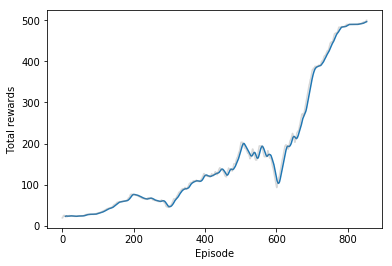

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

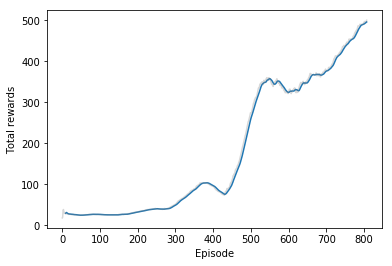

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

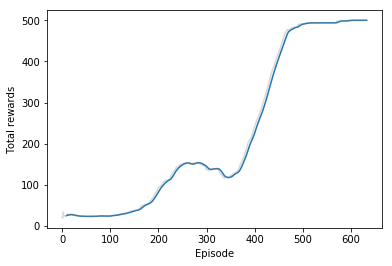

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

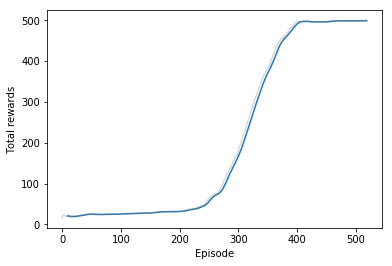

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

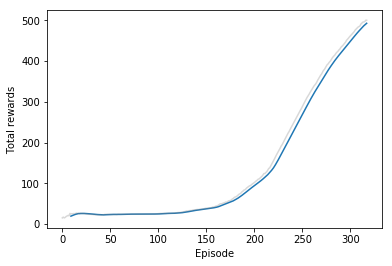

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

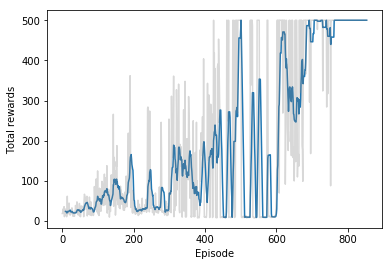

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

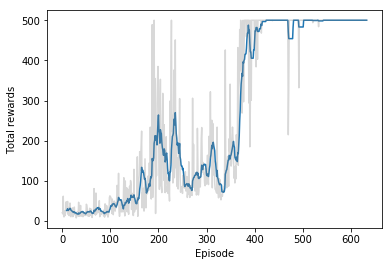

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

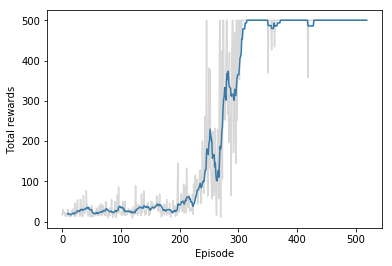

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

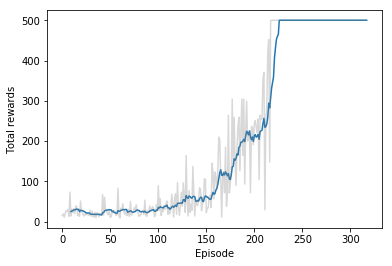

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

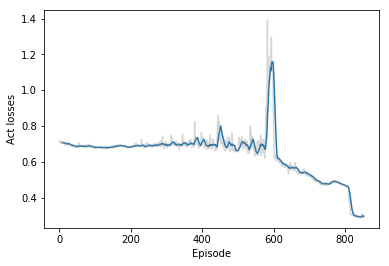

In [21]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

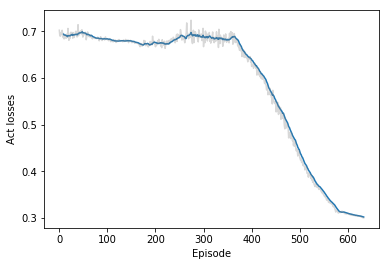

In [21]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

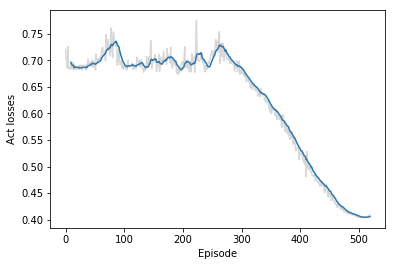

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

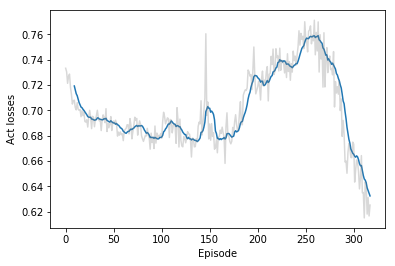

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

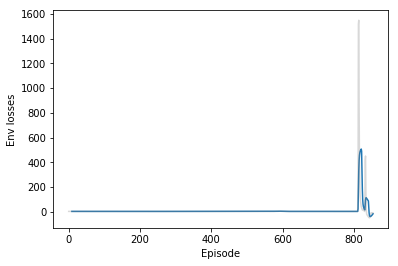

In [22]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

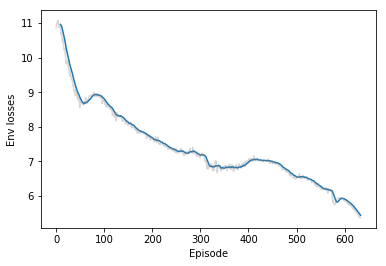

In [22]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

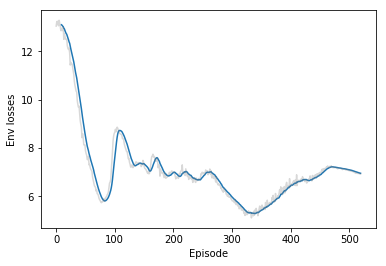

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

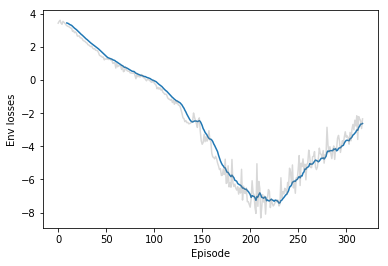

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

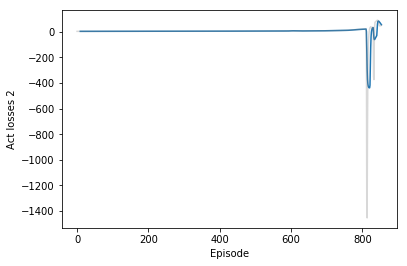

In [23]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

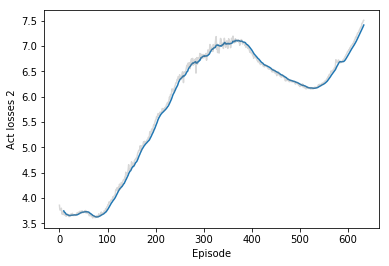

In [23]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

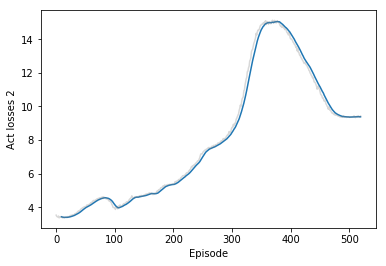

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

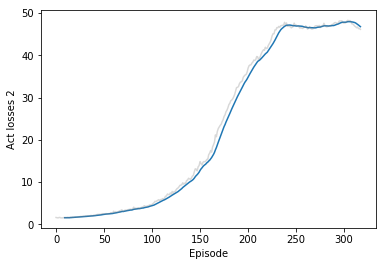

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
